In [1]:
import os, sys
id = 1
os.environ['CUDA_VISIBLE_DEVICES'] = str(id)

sys.path.append('/home/shataxi.dubey/shataxi_work/VLM_high_res')
from json_format import *

In [2]:
import matplotlib.pyplot as plt
from paligemma2_utils import *

#### Set parameters before training

In [3]:
dynamic_dir = '../dynamic_train'

region = "lucknow"
train_on_both_bg_non_bg = True

if region == "wb":
    source_training_set_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/west_bengal_small_639_sq_km/kiln_images/train' 
    validation_set_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/west_bengal_small_639_sq_km/kiln_images/valid' 
    test_set_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/west_bengal_small_639_sq_km/kiln_images/test' 
if region == 'lucknow':
    source_training_set_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/lucknow_small_600_sq_km/kiln_images/train' 
    validation_set_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/lucknow_small_600_sq_km/kiln_images/valid' 
    test_set_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/lucknow_small_600_sq_km/kiln_images/test'

if region == 'lucknow' and train_on_both_bg_non_bg:
    source_training_set_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/lucknow_small_600_sq_km/kiln_images/train_with_background_images' 
    validation_set_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/lucknow_small_600_sq_km/kiln_images/valid' 
    test_set_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/lucknow_small_600_sq_km/kiln_images/test'
if region == "wb" and train_on_both_bg_non_bg:
    source_training_set_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/west_bengal_small_639_sq_km/kiln_images/train_with_background_images' 
    validation_set_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/west_bengal_small_639_sq_km/kiln_images/valid' 
    test_set_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/west_bengal_small_639_sq_km/kiln_images/test'
    
images_file_path = f'{dynamic_dir}/images'
label_files_path = f'{dynamic_dir}/labels'
json_file_path = f'{dynamic_dir}/paligemma2_annotations.jsonl'
is_dota_dataset = False
task = 'detect brick kilns with chimney'
model_name = 'paligemma2'
obb = True
image_type = 'png'
annotation_format = 'yolo'


num_train_epochs = 50
batch_size = 4
gradient_update_steps = 1

#### Training

Total number of images in the training set 148
JSONL file created at location ../dynamic_train/paligemma2_annotations.jsonl
train dataset length 148 test dataset length 25
Number of kilns in train dataset:
Total number of kilns in the dataset 99
Number of kilns in test dataset:
Total number of kilns in the dataset 25


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 11,876,352 || all params: 3,045,003,504 || trainable%: 0.3900


It is strongly recommended to train Gemma2 models with the `eager` attention implementation instead of `sdpa`. Use `eager` with `AutoModelForCausalLM.from_pretrained('<path-to-checkpoint>', attn_implementation='eager')`.


Step,Training Loss
37,2.494700
74,1.920600
111,1.783000
148,1.662800
185,1.614800
222,1.570100
259,1.462700
296,1.386400
333,1.290400
370,1.169100


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Suffix 
Predicted 


100%|██████████| 7/7 [01:44<00:00, 14.90s/it]

Metrics from model trained on 98 kiln images and 50 background images


Plot of Confusion matrix at IoU 0.7


,IoU,Precision,Recall,F1 score,TP,FP,FN,Kiln instances,mAP@50
0,0.1,0.904762,0.76,0.826087,19.0,2.0,6.0,25.0,0.638738
0,0.3,0.904762,0.76,0.826087,19.0,2.0,6.0,25.0,0.638738
0,0.5,0.809524,0.68,0.739130,17.0,4.0,8.0,25.0,0.638738
0,0.7,0.666667,0.56,0.608696,14.0,7.0,11.0,25.0,0.638738


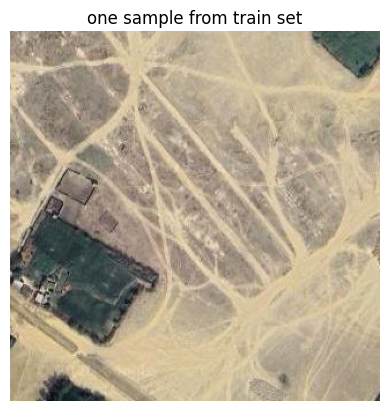

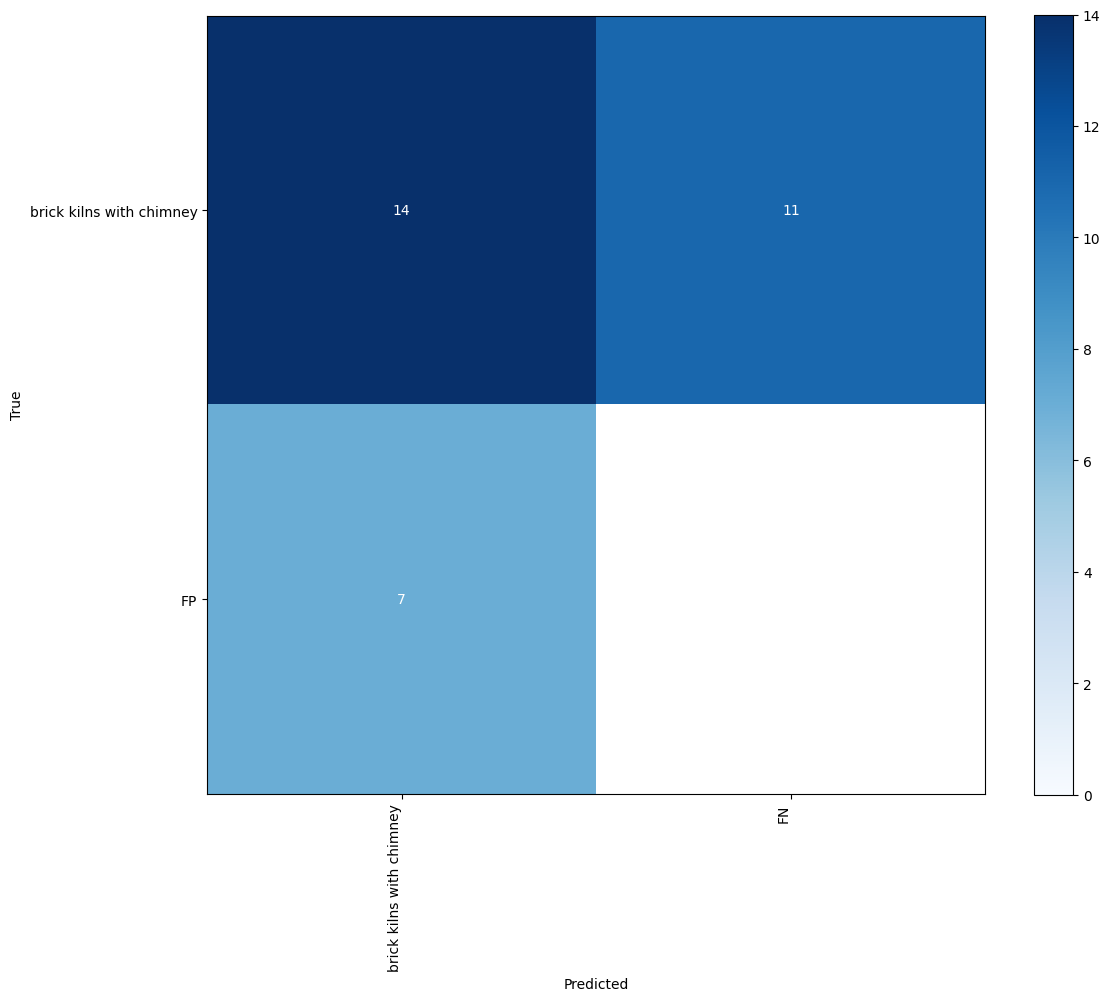

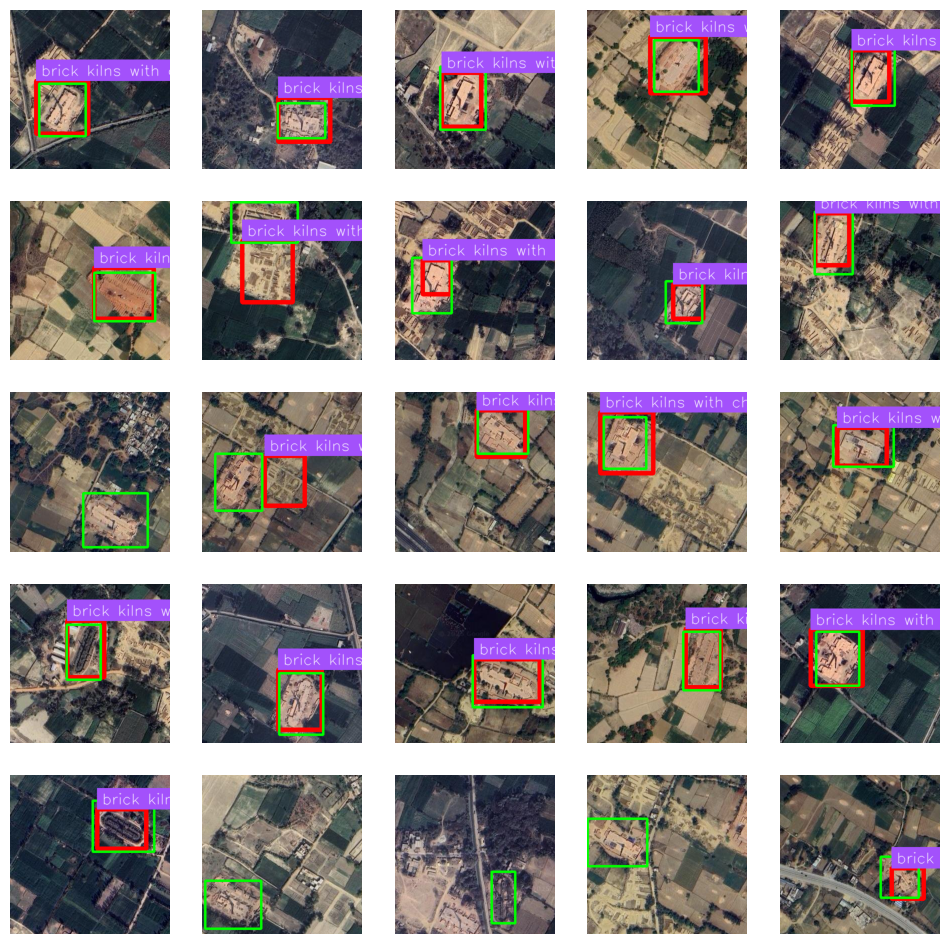

In [4]:
num_bg_image = 50
for num_non_bg_image in [98]:
    MODEL_ID ="google/paligemma2-3b-pt-448"
    model_checkpoint = ''
    create_train_directory(dynamic_dir, source_training_set_path, num_non_bg_image, num_bg_image, type = 'png')
    create_jsonl_file(images_file_path, label_files_path, json_file_path, is_dota_dataset, task, model_name, obb, image_type, annotation_format)
    train_dataset, valid_dataset, test_dataset = create_jsonl_dataset(dynamic_dir, validation_set_path, test_set_path)
    print(f'train dataset length {len(train_dataset)} test dataset length {len(test_dataset)}')
    print(f'Number of kilns in train dataset:')
    num_kilns_in_dataset(train_dataset)
    print(f'Number of kilns in test dataset:')
    num_kilns_in_dataset(test_dataset)
    CLASSES = test_dataset[0][1]['prefix'].replace("detect ", "").split(" ; ")
    model, processor, TORCH_DTYPE = load_model(MODEL_ID, model_checkpoint)
    output_dir = f"{region}_paligemma2_object_detection_{num_non_bg_image}_{num_bg_image}_r_8_alpha_8_gms_batch_size_{batch_size}"
    trainer, steps = set_trainer(model, processor, train_dataset, valid_dataset, num_train_epochs, batch_size, gradient_update_steps, output_dir, TORCH_DTYPE)
    trainer.train()

    model_checkpoint = f'/home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/{output_dir}/checkpoint-{steps}'
    model, processor, TORCH_DTYPE = load_model(MODEL_ID, model_checkpoint)
    annotated_image = sample_test(train_dataset, model, processor, CLASSES, TORCH_DTYPE)
    plt.imshow(annotated_image)
    plt.gca().set_axis_off()
    plt.title(f'one sample from train set')

    targets, predictions, images = evaluate_finetuned_paligemma_model(test_dataset, processor, model, CLASSES, TORCH_DTYPE)
    map_result, map50, map50_95 = calculate_map(predictions, targets)
    print(f'Metrics from model trained on {num_non_bg_image} kiln images and {num_bg_image} background images')
    df = calculate_confusion_matrix(predictions, targets, CLASSES, map_result)
    display(df)
    visualize_predictions(images, predictions, targets, start = 0, end = 25, rows = 5, cols = 5)

#### Inference

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 7/7 [01:29<00:00, 12.77s/it]

google/paligemma2-3b-pt-448


Plot of Confusion matrix at IoU 0.7


,IoU,Precision,Recall,F1 score,TP,FP,FN,Kiln instances,mAP@50
0,0.1,0.28,0.28,0.28,7.0,18.0,18.0,25.0,0.019414
0,0.3,0.20,0.20,0.20,5.0,20.0,20.0,25.0,0.019414
0,0.5,0.12,0.12,0.12,3.0,22.0,22.0,25.0,0.019414
0,0.7,0.00,0.00,0.00,0.0,25.0,25.0,25.0,0.019414


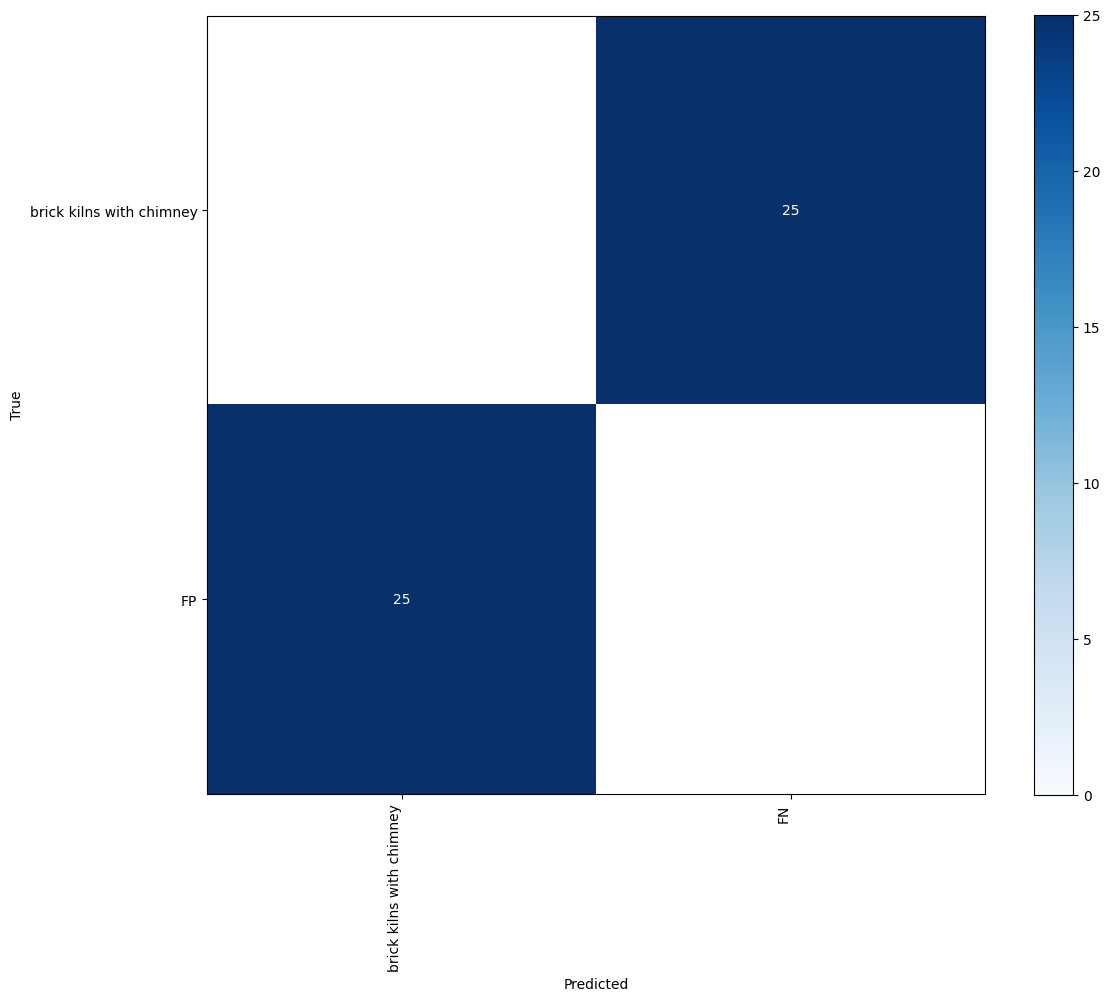

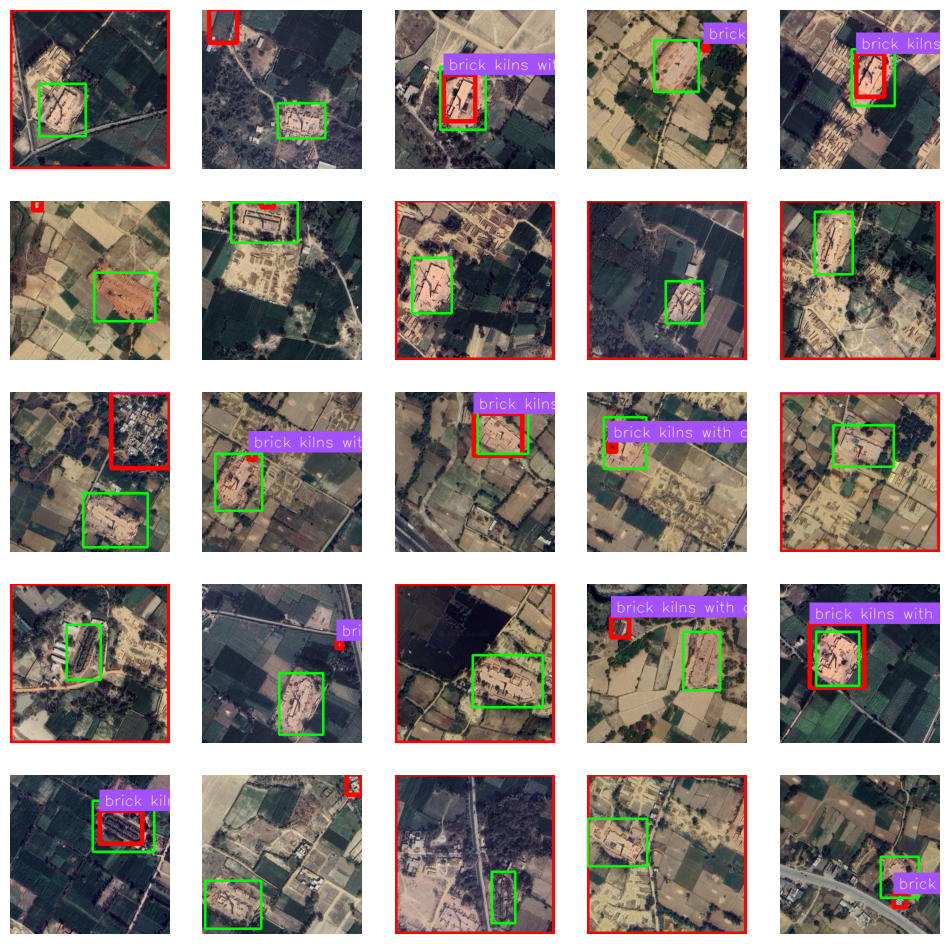

In [ ]:
test_both_kilns_background_images = False
region = 'lucknow' # lucknow, west_bengal

lucknow_model_checkpoints = [
    # '/home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/paligemma2_object_detection_1_0_r_8_alpha_8_gms/checkpoint-50',
    # '/home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/paligemma2_object_detection_2_0_r_8_alpha_8_gms/checkpoint-50',
    # '/home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/paligemma2_object_detection_3_0_r_8_alpha_8_gms/checkpoint-50',
    # '/home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/paligemma2_object_detection_4_0_r_8_alpha_8_gms/checkpoint-50',
    # '/home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/paligemma2_object_detection_5_0_r_8_alpha_8_gms/checkpoint-100',
    # '/home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/paligemma2_object_detection_7_0_r_8_alpha_8_gms/checkpoint-100',
    # '/home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/paligemma2_object_detection_10_0_r_8_alpha_8_gms/checkpoint-150',
    # '/home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/paligemma2_object_detection_20_0_r_8_alpha_8_gms/checkpoint-100',
    # '/home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/paligemma2_object_detection_30_0_r_8_alpha_8_gms/checkpoint-50',
    # '/home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/paligemma2_object_detection_40_0_r_8_alpha_8_gms/checkpoint-100',
    # '/home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/paligemma2_object_detection_60_0_r_8_alpha_8_gms/checkpoint-100',
    # '/home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/paligemma2_object_detection_98_0_r_8_alpha_8_gms/checkpoint-200',
    # '/home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/lucknow_paligemma2_object_detection_98_50_r_8_alpha_8_gms/checkpoint-250',
    '/home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/lucknow_paligemma2_object_detection_98_50_r_8_alpha_8_gms_batch_size_4/checkpoint-1850'
]


wb_model_checkpoints = ['/home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/wb_paligemma2_object_detection_1_0_r_8_alpha_8_gms/checkpoint-50',
                        '/home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/wb_paligemma2_object_detection_2_0_r_8_alpha_8_gms/checkpoint-50',
                        '/home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/wb_paligemma2_object_detection_3_0_r_8_alpha_8_gms/checkpoint-50',
                        '/home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/wb_paligemma2_object_detection_4_0_r_8_alpha_8_gms/checkpoint-50',
                        '/home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/wb_paligemma2_object_detection_5_0_r_8_alpha_8_gms/checkpoint-100',
                        '/home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/wb_paligemma2_object_detection_7_0_r_8_alpha_8_gms/checkpoint-100',
                        '/home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/wb_paligemma2_object_detection_10_0_r_8_alpha_8_gms/checkpoint-150',
                        '/home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/wb_paligemma2_object_detection_20_0_r_8_alpha_8_gms/checkpoint-100',
                        '/home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/wb_paligemma2_object_detection_30_0_r_8_alpha_8_gms/checkpoint-50',
                        '/home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/wb_paligemma2_object_detection_40_0_r_8_alpha_8_gms/checkpoint-100',
                        '/home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/wb_paligemma2_object_detection_60_0_r_8_alpha_8_gms/checkpoint-100',
                        '/home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/wb_paligemma2_object_detection_98_0_r_8_alpha_8_gms/checkpoint-200',           
]   

if region == 'lucknow':
    training_set_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/lucknow_small_600_sq_km/kiln_images/train'
    validation_set_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/lucknow_small_600_sq_km/kiln_images/valid'        
    if test_both_kilns_background_images:
        test_set_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/lucknow_small_600_sq_km/kiln_images/test_with_background_images'
    else:
        test_set_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/lucknow_small_600_sq_km/kiln_images/test'

    checkpoints = lucknow_model_checkpoints

if region == 'west_bengal':
    training_set_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/west_bengal_small_639_sq_km/kiln_images/train'
    validation_set_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/west_bengal_small_639_sq_km/kiln_images/valid'
    if test_both_kilns_background_images:
        test_set_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/west_bengal_small_639_sq_km/kiln_images/test_with_background_images'
    else:
        test_set_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/west_bengal_small_639_sq_km/kiln_images/test'

    checkpoints = wb_model_checkpoints

writer = pd.ExcelWriter(f'Paligemma_train_Lucknow_test_{region}.xlsx', engine = 'xlsxwriter')
row = 0

for model_checkpoint in lucknow_model_checkpoints:
    MODEL_ID ="google/paligemma2-3b-pt-448"

    train_dataset, valid_dataset, test_dataset = create_jsonl_dataset(training_set_path, validation_set_path, test_set_path)

    CLASSES = test_dataset[0][1]['prefix'].replace("detect ", "").split(" ; ")

    model, processor, TORCH_DTYPE = load_model(MODEL_ID, model_checkpoint)

    targets, predictions, images = evaluate_finetuned_paligemma_model(test_dataset, processor, model, CLASSES, TORCH_DTYPE)
    map_result, map50, map50_95 = calculate_map(predictions, targets)
    print(f'{model_checkpoint}')
    df = calculate_confusion_matrix(predictions, targets, CLASSES, map_result)
    df.index = [model_checkpoint]*len(df)
    df.to_excel(writer, sheet_name="Sheet1", startrow = row)
    row += len(df) + 2
    display(df)
    visualize_predictions(images, predictions, targets, start = 0, end = 25, rows = 5, cols = 5)

In [8]:
from supervision.detection.utils import box_iou_batch

iou = box_iou_batch(boxes_true = targets[3].xyxy, boxes_detection = predictions[3].xyxy)
print(iou)
map_result, map50, map50_95 = calculate_map(predictions[3:4], targets[3:4])
map50

[]


0.0

#### visualize images with kilns

In [ ]:
filtered_predictions = []
filtered_targets = []
filtered_images = []
for i, target in enumerate(targets):
    if len(target.xyxy):
        filtered_targets.append(target)
        filtered_predictions.append(predictions[i])
        filtered_images.append(images[i])
visualize_predictions(filtered_images, filtered_predictions, filtered_targets, start=0, end = 25, rows=5, cols=5)